### Questions to Explore:
1. What feature selection methods will improve the final spearman score the most?
2. Can we improve DHA_1C50 prediction values by using a dataset that only includes the DHA-treated, 24 hour samples? Or 6 hr samples?

### Tasks Completed: 
- Create different dataframes (ex: all time/treatments, treated_24hr, treated_6hr, treated_all, etc) and test each dataframe individually in the model
- Try various feature selection methods on the different dataframes
- Select the best dataframe (if one is better than full dataframe) and feature selection method

# Best Results Found with:
- f-regression feature selection
  


### Feature Selection Methods (all with SVM)
1. [Baseline scores](#baseline)
2. [Univariate: f_regression](#fregression)


3. [Cosine similarity between bioreps](#cosreps)
4. [Spearman similarity between bioreps](#spearreps)
5. [Pearson similarity between bioreps](#pearreps)


6. [Cosine similarity between treatments](#costreat)


7. [Spearman correlation with target](#speartar)
8. [Pearson correlation with target](#peartar)
9. [Cosine similarity with target](#costar)

Still to do
- covariance with target

- multivariate, mutual info
- recursive
- pca

- covariance between bioreps? (might be the same as pearson if they are normalized)

    

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression


## Create dataframes

In [25]:
#dataframe containing all features
train_full = pd.read_csv("SubCh1_TrainingData.csv")
test_full = pd.read_csv("SubCh1_TestData.csv")
#convert values to numerical and drop unnecessary columns
train_full['Timepoint'] = [1 if i == '24HR' else 0 for i in train_full['Timepoint']]
train_full['Treatment'] = [1 if i == 'DHA' else 0 for i in train_full['Treatment']]
train_full['BioRep'] = [int(i[-1]) for i in train_full['BioRep']]
train_full = train_full.drop(['Sample_Name', 'Isolate'], axis = 1)

y = train_full[['DHA_IC50']]          #target variable
print(y.shape)
print(train_full.shape)               #df with all features

train_full.head()

(272, 1)
(272, 5544)


,Timepoint,Treatment,BioRep,MAL1.465720.465873.bc..rv..,MAL1.48287.48430....kr...can,MAL1.562126.562246.bc..r...,MAL1.59416.59687....kr...can,MAL1.616633.616682.......y.,MAL10.1139073.1139243....kr,MAL10.258733.258825.b...r..,...,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,1,1,1,0.008286,-0.959492,0.206468,-0.443936,0.453030,0.291222,-0.157282,...,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,1,1,2,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,-0.368476,2.566465,...,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,1,0,1,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,1.037573,1.733154,...,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,1,0,2,0.125177,-1.462758,-1.888105,-0.828352,-1.410803,0.926191,2.644319,...,-0.659519,-5.011207,-0.559471,-2.266763,-5.289318,-2.949869,-2.206432,-4.324299,-1.735312,2.177
4,0,1,1,1.354956,-2.139128,-0.541696,-1.481881,-0.735798,-0.129961,2.707328,...,-1.687048,-4.773306,-0.048847,-2.023727,-4.398358,-3.080500,-0.566545,-4.798190,-0.821690,2.177


In [26]:
# create df with only genes, change gene names
train = train_full.drop(['BioRep', 'DHA_IC50', 'Timepoint', 'Treatment'], axis=1)
train.columns = ['X' + str(i) for i in range(1, 5541)]
train.head(1)  

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X5531,X5532,X5533,X5534,X5535,X5536,X5537,X5538,X5539,X5540
0,0.008286,-0.959492,0.206468,-0.443936,0.45303,0.291222,-0.157282,-1.67681,0.37707,0.3304,...,0.210607,-0.540993,-3.674097,-1.652979,-2.25549,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528


In [27]:
# create different dataframes that only have rows with corresponding treatment and timepoints
X_one = train.loc[:]                            #df with only gene expression data

X_t = X_two[(X_two['Treatment']==1)]           # df with selected timepoint/treatement rows
y_t = train_full[(train_full['Treatment']==1)][['DHA_IC50']]

X_t24 = X_two[(X_two['Treatment']==1) & (X_two['Timepoint'] ==1)]
y_t24 = train_full[(train_full['Treatment']==1)&(train_full['Timepoint'] == 1)][['DHA_IC50']]


X_t6 = X_two[(X_two['Treatment']==1) & (X_two['Timepoint'] ==0)]
y_t6 = train_full[(train_full['Treatment']==1)&(train_full['Timepoint'] == 0)][['DHA_IC50']]

X_u = X_two[(X_two['Treatment']==0)]
y_u = train_full[(train_full['Treatment']==0)][['DHA_IC50']]

X_u24 = X_two[(X_two['Treatment']==0) & (X_two['Timepoint'] ==1)]
y_u24 = train_full[(train_full['Treatment']==0)&(train_full['Timepoint'] == 1)][['DHA_IC50']]

X_u6 = X_two[(X_two['Treatment']==0) & (X_two['Timepoint'] ==0)]
y_u6 = train_full[(train_full['Treatment']==0)&(train_full['Timepoint'] == 0)][['DHA_IC50']]

                                                                                         
# example of how globals will work
X_frames = ['X_one', 'X_two', 'X_three', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y', 'y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    print(x[0], x_frame.shape, x[1], y_frame.shape)

X_one (272, 5540) y (272, 1)
X_two (272, 5542) y (272, 1)
X_three (272, 5541) y (272, 1)
X_u (136, 5542) y_u (136, 1)
X_u6 (68, 5542) y_u6 (68, 1)
X_u24 (68, 5542) y_u24 (68, 1)
X_t (136, 5542) y_t (136, 1)
X_t6 (68, 5542) y_t6 (68, 1)
X_t24 (68, 5542) y_t24 (68, 1)


<a id='baseline'><a/>

## 1. Baseline Scores:  SVM, All features, Gridsearch best params for each df

In [32]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]


import warnings
warnings.filterwarnings("ignore", message="invalid value encountered")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [110]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']

dataframe = []    #for best gridsearch results
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame.values.ravel(), 
                                                        test_size = 0.33, random_state = 33)
#gridsearch results
    svc = svm.SVR()
    params = {        
                 'kernel': ['rbf', 'poly', 'sigmoid'],
                      'C': [0.1, 1, 10 ],
                'epsilon': [0.01,  0.1, 0.2],
                  'gamma': [0.001, 0.01, 'auto'], 
                 'degree': [2, 3, 4]                  }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                      return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    gs_results = pd.DataFrame(gs.cv_results_)
    best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results (cv=3)   
    dataframe.append(x[0])
    best_params.append(best_scores_df.loc[0, 'params'])
    gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
    gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
    gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
    gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
    gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
    gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
# final score using the best gridsearch params
    svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                 epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)
    train_pred = model.predict(X_train)
#for final score df        
    test_spear.append(round(spearmanr(y_test, pred)[0], 3))
    test_r2.append(round(r2_score(y_test, pred), 3))
    test_mse.append(round(mean_squared_error(y_test, pred), 3))
    test_pval.append(round(spearmanr(y_test, pred)[1], 3))
    train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
    train_r2.append(round(r2_score(y_train, train_pred), 3))
    train_mse.append(round(mean_squared_error(y_train, train_pred), 3))


all_results = pd.DataFrame(list(zip(dataframe, best_params, gs_test_spear, gs_train_spear, gs_test_r2, gs_train_r2, 
                    gs_test_mse, gs_train_mse, test_spear, train_spear, test_r2, train_r2, 
                    test_mse, train_mse, test_pval)),
            columns=['x_frame', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 'gs_train_r2',
                     'gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])


In [112]:
# baseline_results = all_results.loc[:]
baseline_results['best_params'].values

array([{'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}],
      dtype=object)

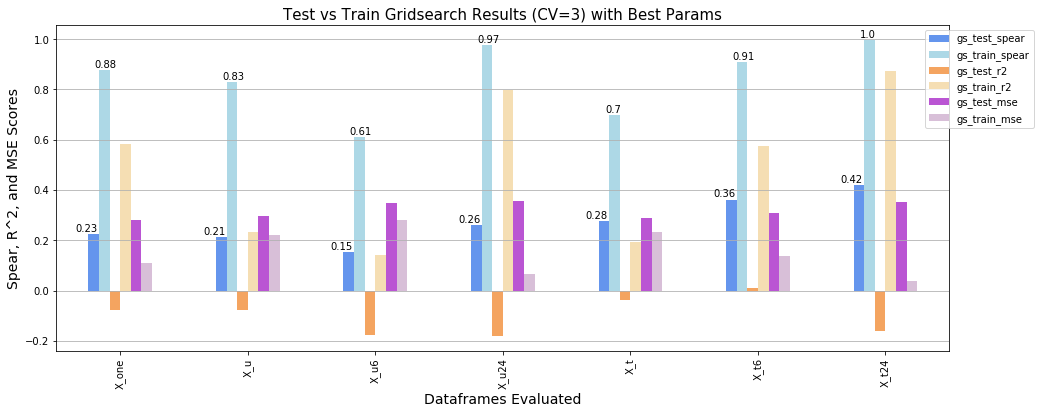

In [377]:
baseline_gs = baseline_results.loc[:, ['x_frame', 'gs_test_spear','gs_train_spear','gs_test_r2', 'gs_train_r2',
                     'gs_test_mse', 'gs_train_mse']].set_index('x_frame')

color_list = ['cornflowerblue','lightblue','sandybrown','wheat','mediumorchid','thistle']

f = plt.figure(figsize = (16, 6))
ax = baseline_gs.plot(kind = 'bar', color = color_list, ax=f.gca())

ax.set_title("Test vs Train Gridsearch Results (CV=3) with Best Params", fontsize = 15)
ax.set_xlabel("Dataframes Evaluated", fontsize = 14)
ax.set_ylabel("Spear, R^2, and MSE Scores", fontsize = 14)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.1 ,1))
ax.yaxis.grid()
for index, value in enumerate(baseline_gs['gs_test_spear']):
    plt.annotate(round(value, 2), xy=(index-0.35, value+0.01))
for index, value in enumerate(baseline_gs['gs_train_spear']):
    plt.annotate(round(value, 2), xy=(index - 0.2, value+0.01))

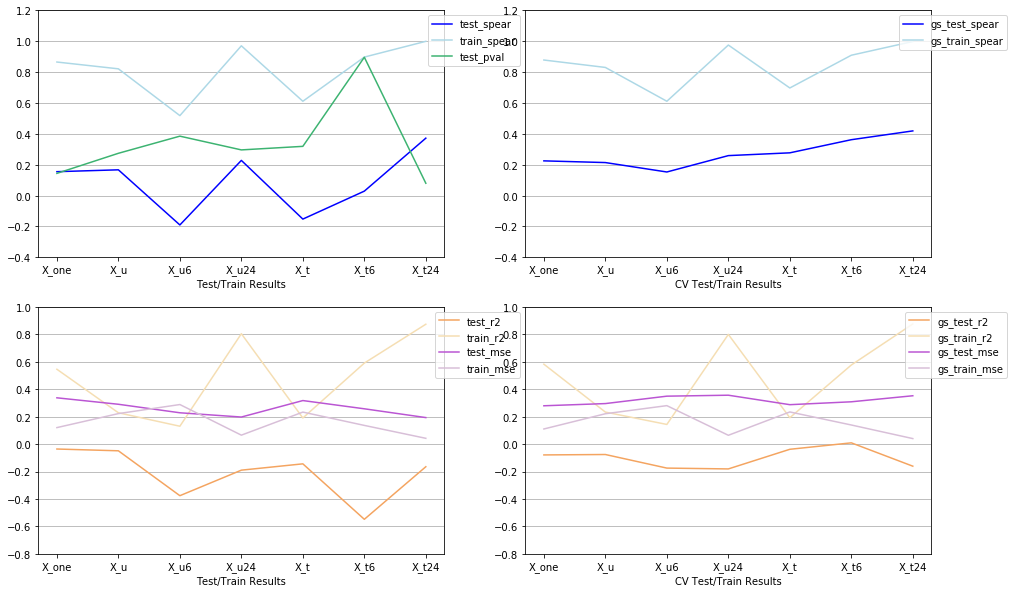

In [120]:
base_1 = baseline_results.loc[:, ['x_frame', 'test_spear', 'train_spear', 'test_pval']].set_index('x_frame')
base_2 = baseline_results.loc[:, ['x_frame', 'test_r2', 'train_r2', 'test_mse', 'train_mse']].set_index('x_frame')
gs_1 = baseline_results.loc[:, ['gs_test_spear', 'gs_train_spear']]
gs_2 = baseline_results.loc[:, ['gs_test_r2', 'gs_train_r2', 'gs_test_mse', 'gs_train_mse']]


plt.figure(figsize = (16, 10))
ax1 = plt.subplot(221)
base_1.plot(kind = 'line', ax = ax1, color = ['blue','lightblue', 'mediumseagreen' ])
plt.xlabel("Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax1.get_yticks())
ax1.yaxis.grid()
ax1.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax2 = plt.subplot(222)
gs_1.plot(kind = 'line', ax = ax2, color = ['blue','lightblue'])
plt.xlabel("CV Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax1.get_yticks())
ax2.yaxis.grid()
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax3 = plt.subplot(223)
base_2.plot(kind = 'line', ax = ax3, color = ['sandybrown','wheat','mediumorchid','thistle'])
plt.xlabel("Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax3.get_yticks())
ax3.yaxis.grid()
ax3.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax4 = plt.subplot(224)
gs_2.plot(kind = 'line', ax = ax4, color = ['sandybrown','wheat','mediumorchid','thistle'])
plt.xlabel("CV Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax3.get_yticks())
ax4.yaxis.grid()
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
plt.show()

# Feature Selection Methods

<a id='fregression'><a/>
## 2. Univariate f-regression

In [129]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']


dataframe = []    #for gridsearch results
k_features = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []


for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    for j in np.arange(10, 260, 40):
        X_new = SelectKBest(f_regression, k=j).fit_transform(x_frame , y_frame.values.ravel()) 
        X_new = pd.DataFrame(data = X_new)

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
    #gridsearch results
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10 ],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 3, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#         print(best_scores_df['params'].values)
#         print("----------------------------------------------------------")
    #gridsearch results df    
        dataframe.append(x[0])
        k_features.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
    # final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
    #for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, k_features, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'k=features', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])


In [440]:
# f_results = all_results.loc[:]
f_bestparams = f_results['best_params'].values
for i, row in enumerate(f_bestparams):
    print(i, row)

0 {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
1 {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
2 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
3 {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
4 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
5 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
6 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
7 {'C': 0.1, 'degree': 3, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
8 {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
9 {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
10 {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
11 {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
12 {'C': 10, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
13 {'C': 1, 'de

In [439]:
f_results.drop('best_params', axis = 1)

,x_frame,k=features,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X_one,10,0.256,0.536,0.030,0.288,0.250,0.187,0.253,0.512,0.053,0.274,0.308,0.191,0.016
1,X_one,50,0.341,0.744,0.026,0.351,0.251,0.170,0.391,0.733,0.053,0.349,0.309,0.172,0.000
2,X_one,90,0.374,0.821,-0.019,0.483,0.262,0.136,0.401,0.798,0.104,0.464,0.292,0.141,0.000
3,X_one,130,0.351,0.895,-0.059,0.597,0.271,0.106,0.387,0.876,0.107,0.569,0.291,0.114,0.000
4,X_one,170,0.339,0.828,0.003,0.474,0.256,0.138,0.338,0.810,0.066,0.453,0.304,0.144,0.001
5,X_one,210,0.346,0.829,0.013,0.484,0.254,0.136,0.291,0.799,0.023,0.467,0.318,0.140,0.005
6,X_one,250,0.343,0.835,0.007,0.491,0.256,0.134,0.317,0.808,0.027,0.476,0.317,0.138,0.002
7,X_u,10,0.202,0.245,-0.026,0.003,0.289,0.286,0.347,0.220,0.003,0.001,0.276,0.287,0.020
8,X_u,50,0.343,0.284,-0.083,-0.017,0.295,0.291,0.447,0.346,-0.052,-0.010,0.291,0.290,0.002
9,X_u,90,0.334,0.894,-0.746,0.887,0.391,0.031,0.338,0.900,-0.381,0.883,0.382,0.033,0.023


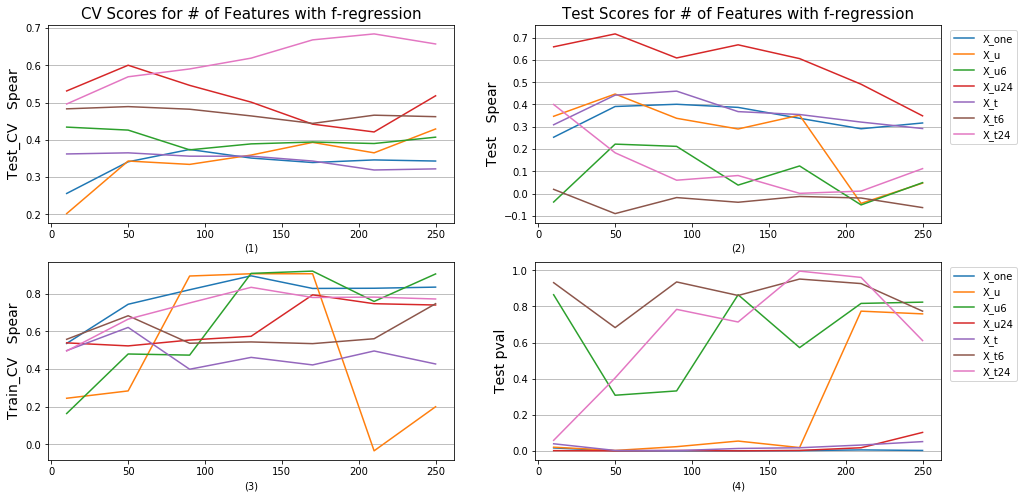

--------------------------------------------------------------------------


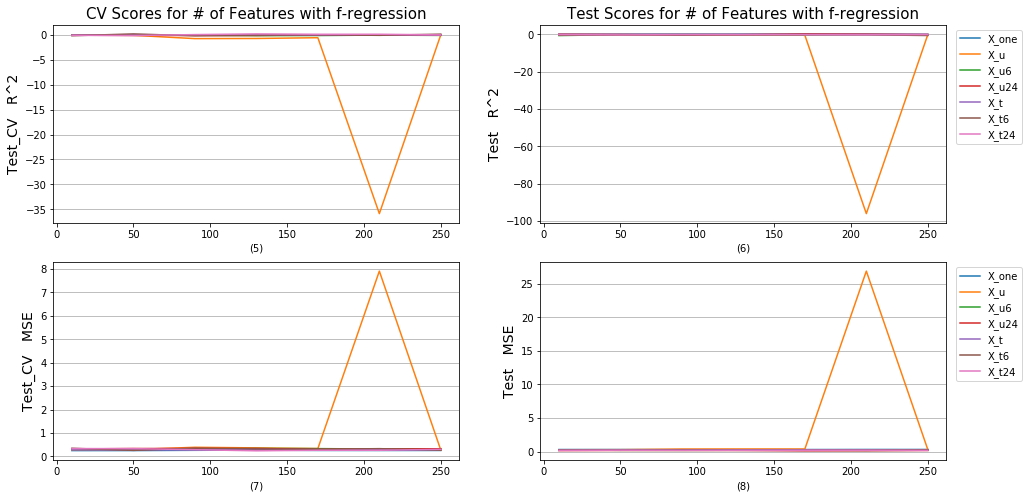

In [379]:
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_spear'], label = j)
ax1.yaxis.grid()
plt.xlabel("(1)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   Spear", fontsize = 14)


ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_spear'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(2)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   Spear", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_train_spear'], label = j)
ax3.yaxis.grid()
plt.xlabel("(3)")
ax3.set_ylabel("Train_CV   Spear", fontsize = 14)


ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_pval'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(4)")
ax4.set_ylabel("Test pval", fontsize = 14)
plt.show()
print("--------------------------------------------------------------------------")
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_r2'], label = j)
ax1.yaxis.grid()
plt.xlabel("(5)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   R^2", fontsize = 14)

ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_r2'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(6)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   R^2", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_mse'], label = j)
ax3.yaxis.grid()
plt.xlabel("(7)")
ax3.set_ylabel("Test_CV   MSE", fontsize = 14)

ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_mse'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(8)")
ax4.set_ylabel("Test   MSE", fontsize = 14)

plt.show()

**Results of f-regression feature selection:**

Best overall:
- Best spearman score comes from `u24`, with `k_features` = 50 features (test_spear = 0.72)
    - In comparison, the full datframe `X_one` has test_spear = 0.4 with 90 features


Other findings:
- While `t6` and `t24` have favorable cv scores, the actual test scores decrease after 10 features, which is reflected in their pvals
- Dataframes that improved from baseline score: `u24`, `t`,`u`, full, 
- The dataframes that did NOT improve from the baseline score: `u6`, `t6`, `t24`
- The df with unrelaiable pvalues with their test scores are: `t6`, `t24`, and `u` with > 180 features

<a id='cosreps'><a/>
    
## 3. Cosine similarty between bioreps (drop features that are NOT similar between reps (below a certain cos sim threshold))
- Idea: Significant genes might not have wildly different measurements in rep 1 vs 2 ---> if a feature in biorep 1 and biorep 2 are NOT within a certain cosine similarity threshold, drop them

In [162]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']


dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_full['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(0.4, 1.0, 0.08):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if cosine_similarity(reps2.values[:,i].reshape(1, -1),reps1.values[:,i].reshape(1, -1))[0][0] < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])



In [164]:
# cos_reps_results = all_results.loc[:]
# cos_reps_bestparams = cos_reps_results['best_params'].values
# cos_reps_bestparams

In [437]:
# cos_reps_results.drop('best_params', axis = 1).head()

In [416]:
def graph_threshold_scores(df, title, x_ax):   
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_spear'], label = j)
    ax1.yaxis.grid()
    plt.xlabel("(1)")
    ax1.set_title("CV Scores for" + title, fontsize = 15)
    ax1.set_ylabel("Test_CV   Spear", fontsize = 14)

    ax2 = plt.subplot(222)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_spear'], label = j)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax2.yaxis.grid()
    plt.xlabel("(2)")
    ax2.set_title("Test Scores for" + title, fontsize = 15)
    ax2.set_ylabel("Test   Spear", fontsize = 14)

    ax3 = plt.subplot(223)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_train_spear'], label = j)
    ax3.yaxis.grid()
    plt.xlabel("(3)")
    ax3.set_ylabel("Train_CV   Spear", fontsize = 14)


    ax4 = plt.subplot(224)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_pval'], label = j)
    ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax4.yaxis.grid()
    plt.xlabel("(4)")
    ax4.set_ylabel("Test pval", fontsize = 14)
    plt.show()
    print("--------------------------------------------------------------------------")
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_r2'], label = j)
    ax1.yaxis.grid()
    plt.xlabel("(5)")
    ax1.set_title("CV Scores for" + title, fontsize = 15)
    ax1.set_ylabel("Test_CV   R^2", fontsize = 14)

    ax2 = plt.subplot(222)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_r2'], label = j)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax2.yaxis.grid()
    plt.xlabel("(6)")
    ax2.set_title("Test Scores for" + title, fontsize = 15)
    ax2.set_ylabel("Test   R^2", fontsize = 14)

    ax3 = plt.subplot(223)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_mse'], label = j)
    ax3.yaxis.grid()
    plt.xlabel("(7)")
    ax3.set_ylabel("Test_CV   MSE", fontsize = 14)

    ax4 = plt.subplot(224)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_mse'], label = j)
    ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax4.yaxis.grid()
    plt.xlabel("(8)")
    ax4.set_ylabel("Test   MSE", fontsize = 14)
    plt.show()
    print("--------------------------------------------------------------------------")
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['num_columns'], label = j)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax1.yaxis.grid()
    plt.xlabel("(9)")
    ax1.set_title("Number of Features Selected", fontsize = 15)
    ax1.set_ylabel("num_columns", fontsize = 14)
    plt.show()  
    return

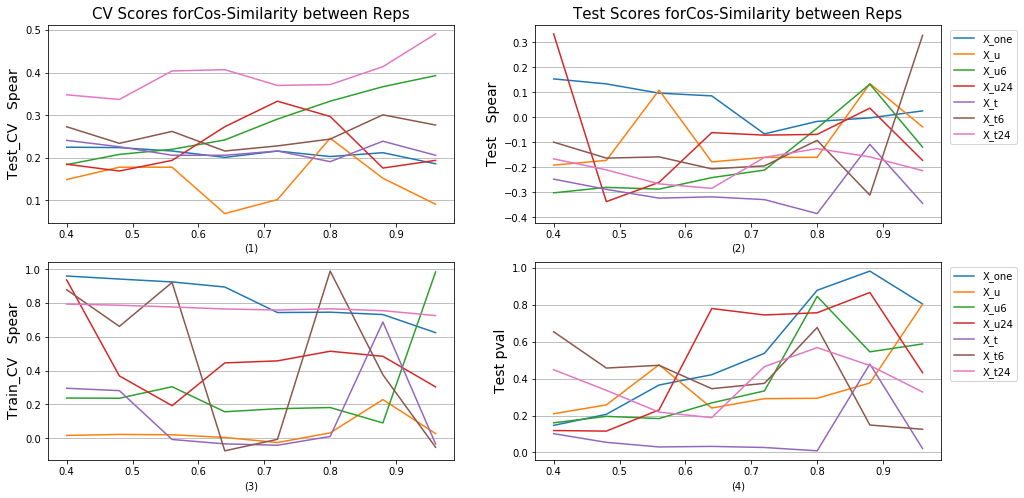

--------------------------------------------------------------------------


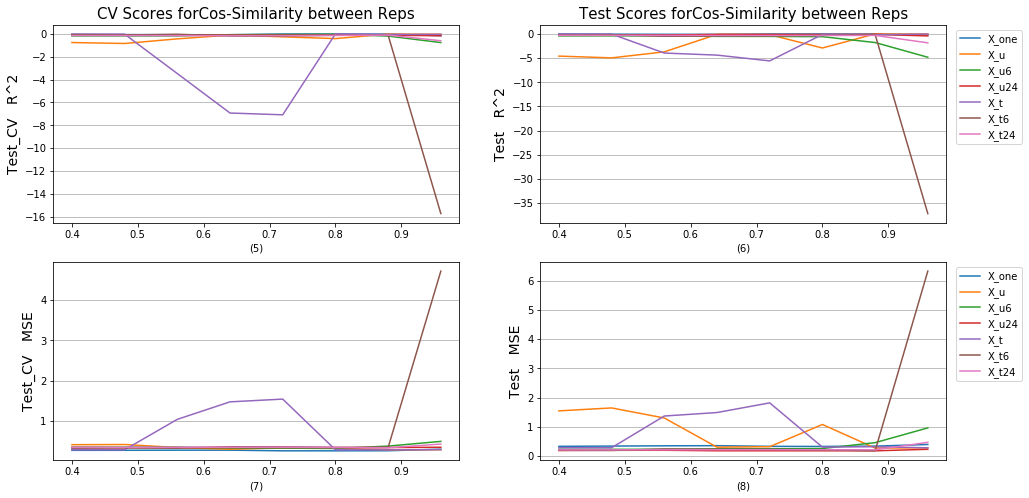

--------------------------------------------------------------------------


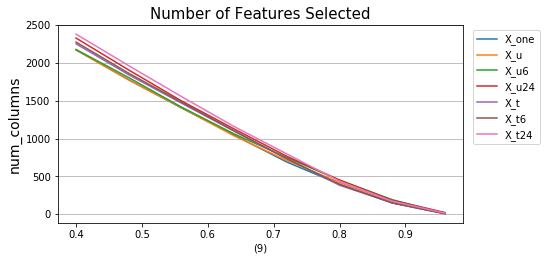

In [417]:
graph_threshold_scores(df = cos_reps_results, title = "Cos-Similarity between Reps", 
                       x_ax = 'threshold')

<a id='spearreps'><a/>
    
## 4. Spearman similarty between bioreps (drop features that are NOT similar between reps))
- Idea: same as before, but with a different ranking metric

In [192]:
#let's determine the approx thresh to use with the first dataframe
X_frames = ['X_one']
y_frames = ['y']
x_frame = globals()[x[0]]
y_frame = globals()[x[1]]

X_cos = x_frame.loc[:]
X_cos['BioRep'] = train_full['BioRep']       #add the biorep column to modified df
reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
X_cos = X_cos.drop(columns= ['BioRep'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(spearmanr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

-0.032167549782432046
0.25458709031057675
-0.3058537283526549


In [199]:
np.arange(-0.2, 0.25, 0.06)
# len(reps2)

array([-0.2 , -0.14, -0.08, -0.02,  0.04,  0.1 ,  0.16,  0.22])

In [200]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']


dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_full['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.2, 0.25, 0.06):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if spearmanr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0]  < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [427]:
# spear_reps_results = all_results.loc[:]
# spear_reps_bestparams = spear_reps_results['best_params'].values
# spear_reps_bestparams 

In [436]:
# spear_reps_results.drop('best_params', axis = 1).head()

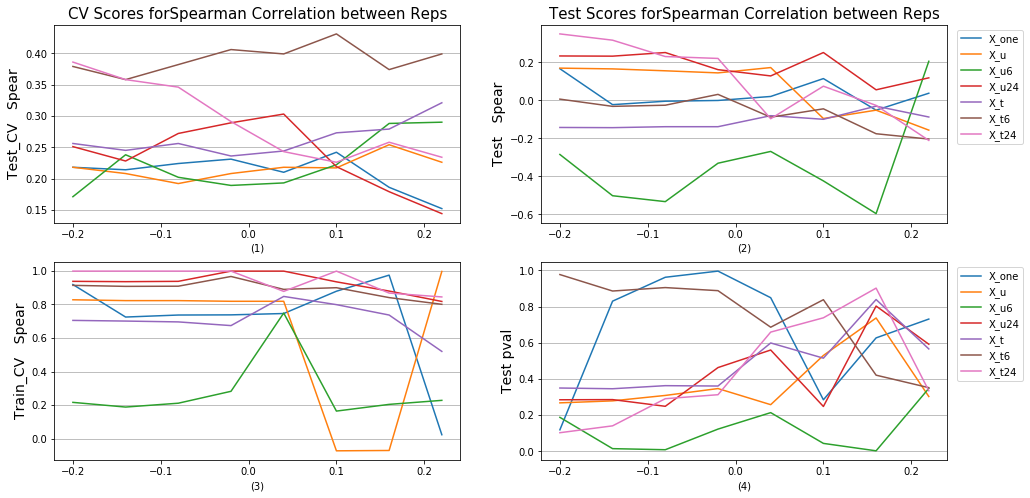

--------------------------------------------------------------------------


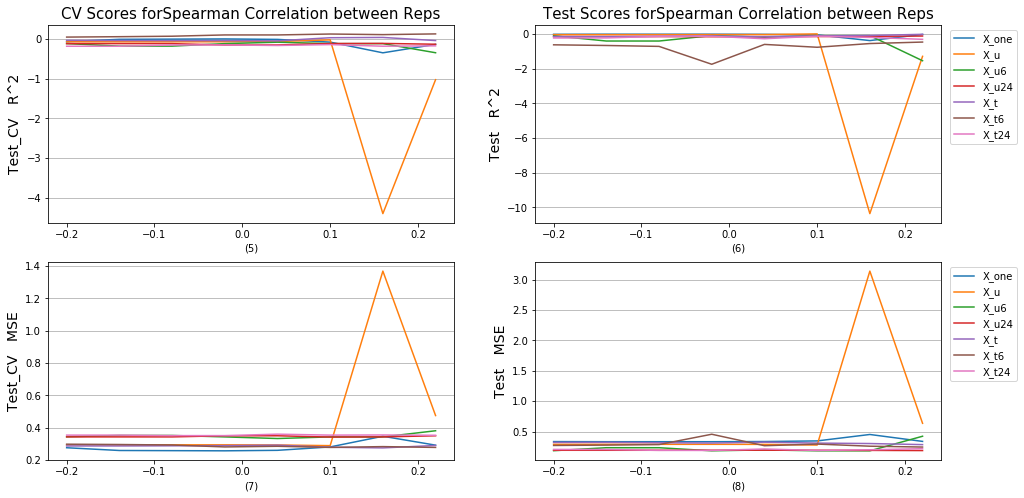

--------------------------------------------------------------------------


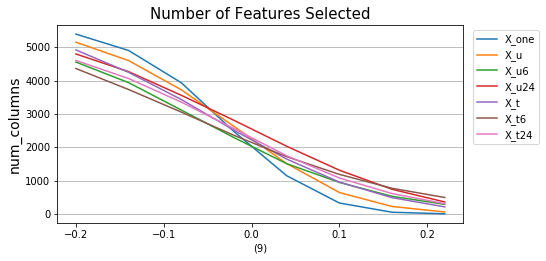

In [418]:
graph_threshold_scores(df = spear_reps_results, title = "Spearman Correlation between Reps", 
                       x_ax = 'threshold')

<a id='pearreps'><a/>
    
## 5.  Pearson correlation between bioreps (drop features that are NOT similar between reps)
- Idea: same as before, but with Pearson 

In [209]:
#determine the approx thresh to use with the first dataframe
X_cos = X_one.loc[:]
X_cos['BioRep'] = train_full['BioRep']       
reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
X_cos = X_cos.drop(columns= ['BioRep'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(pearsonr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  

-0.034796592697431405
0.2550703142264774
-0.28960402169078336


In [210]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']


dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_full['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.2, 0.25, 0.06):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if pearsonr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0]  < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [429]:
# pear_reps_results = all_results.loc[:]
# pear_reps_bestparams = pear_reps_results['best_params'].values
# pear_reps_bestparams

In [435]:
# pear_reps_results.drop('best_params', axis = 1).head()

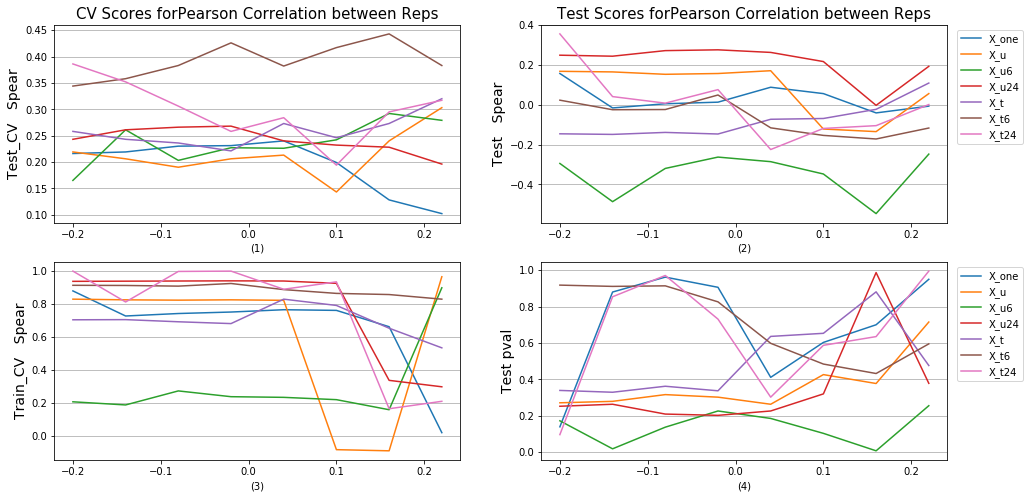

--------------------------------------------------------------------------


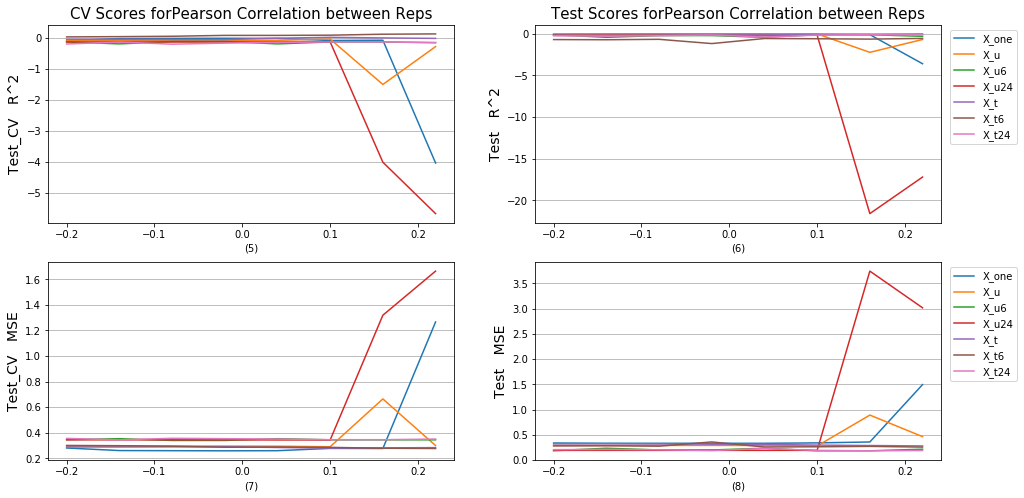

--------------------------------------------------------------------------


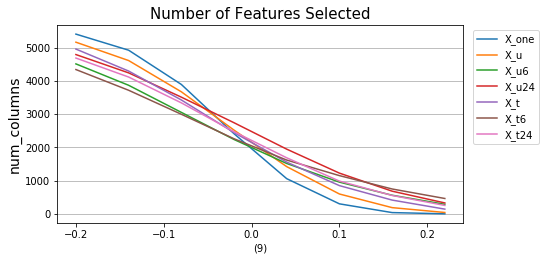

In [419]:
graph_threshold_scores(df = pear_reps_results, title = "Pearson Correlation between Reps", 
                       x_ax = 'threshold')

<a id='costreat'><a/>
## 6. Cosine similarity between treatments (drop genes that are highly similar)

- Idea: maybe some important features will behave differently in untreated vs treated
    - unlike rep1 vs rep1, important features will likely have different measurements in the treated vs untreated samples 
    - drop features that have a cos-sim score above the threshold (if a feature in untreated vs treated has a low similarity, keep it)

In [430]:
X_cos = X_one.loc[:]
X_cos['Treatment'] = train_full['Treatment']
treat1 = X_cos[X_cos['Treatment']==1].drop(columns = ['Treatment'])
treat0 = X_cos[X_cos['Treatment']==0].drop(columns = ['Treatment'])
X_cos = X_cos.drop(columns= ['Treatment'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(cosine_similarity(treat1.values[:,i].reshape(1, -1), treat0.values[:,i].reshape(1, -1))[0][0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  

0.3296787229056707
0.9799476109621147
-0.3632668469510658


In [220]:
np.arange(-0.2, 0.91, 0.1)

array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,
        0.9])

In [256]:
X_frames = ['X_one']
y_frames = ['y']

dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['Treatment'] = train_full['Treatment']
    treat1 = X_cos[X_cos['Treatment']==1].drop(columns = ['Treatment'])
    treat0 = X_cos[X_cos['Treatment']==0].drop(columns = ['Treatment'])
    X_cos = X_cos.drop(columns= ['Treatment'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.2, 0.91, 0.1):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if cosine_similarity(treat1.values[:,i].reshape(1, -1),treat0.values[:,i].reshape(1, -1))[0][0] > drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [257]:
# cos_treat_results = all_results.loc[:]
# cos_treat_bestparams = cos_treat_results['best_params'].values
cos_treat_bestparams

array([{'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'},
       {'C': 10, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}],
      dtype=object)

In [258]:
cos_treat_results.drop('best_params', axis = 1)

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X_one,-0.2,20,0.181,0.338,-0.027,-0.000,0.264,0.262,0.076,0.310,-0.006,0.005,0.328,0.262,0.475
1,X_one,-0.1,179,0.358,0.833,-0.016,0.418,0.262,0.153,0.159,0.812,-0.015,0.397,0.331,0.159,0.134
2,X_one,0.0,749,0.332,0.890,0.015,0.471,0.255,0.139,0.136,0.869,0.010,0.448,0.322,0.145,0.200
3,X_one,0.1,1555,0.336,0.808,0.020,0.310,0.253,0.181,0.157,0.790,0.014,0.305,0.321,0.183,0.140
4,X_one,0.2,2236,0.290,0.849,-0.015,0.464,0.263,0.141,0.126,0.830,-0.013,0.441,0.330,0.147,0.237
5,X_one,0.3,2795,0.252,0.925,-0.054,0.628,0.273,0.098,0.103,0.906,-0.031,0.572,0.336,0.113,0.334
6,X_one,0.4,3375,0.265,0.747,-0.006,0.236,0.259,0.201,0.110,0.728,0.004,0.234,0.325,0.202,0.301
7,X_one,0.5,3868,0.269,0.777,-0.000,0.291,0.258,0.186,0.105,0.752,-0.002,0.282,0.326,0.189,0.325
8,X_one,0.6,4298,0.256,0.797,-0.006,0.334,0.260,0.175,0.101,0.775,-0.006,0.321,0.328,0.179,0.343
9,X_one,0.7,4744,0.246,0.822,-0.022,0.407,0.264,0.156,0.088,0.812,-0.017,0.389,0.331,0.161,0.408


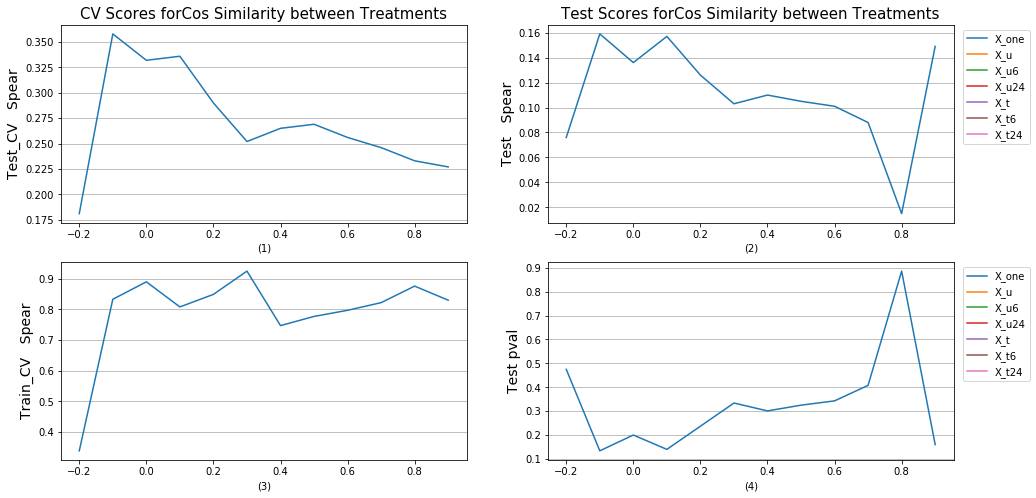

--------------------------------------------------------------------------


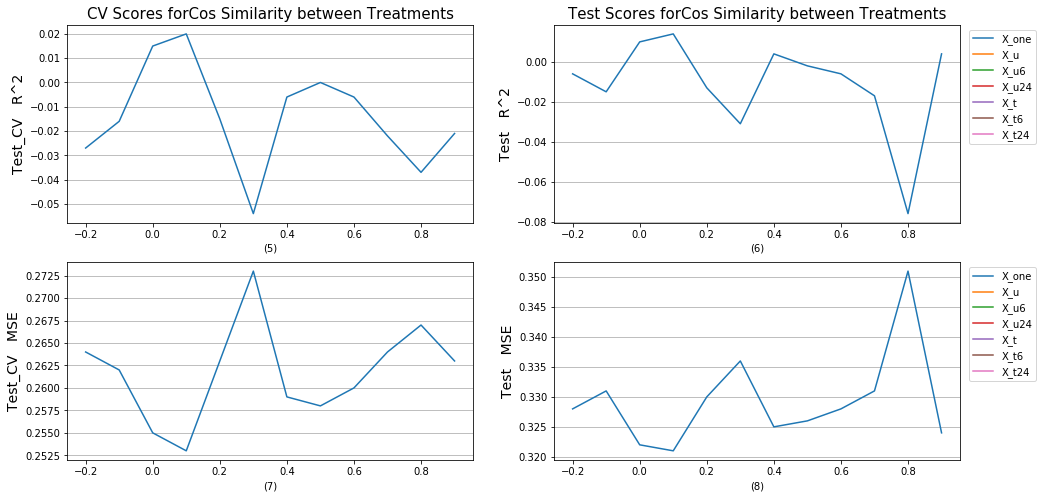

--------------------------------------------------------------------------


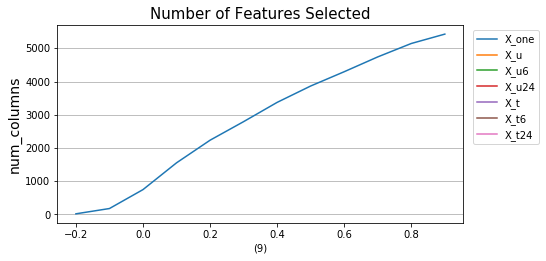

In [420]:
graph_threshold_scores(df = cos_treat_results, title = "Cos Similarity between Treatments", 
                       x_ax = 'threshold')

<a id='speartar'><a/>
## 7. Spearman Correlation with Target


In [421]:
#check the threshold with the first df
X_cos = X_one.loc[:]
stats = []
  
for c in range(len(X_cos.columns)):   
    stats.append(spearmanr(X_cos.iloc[:, c].values.reshape(-1, 1), y.values.reshape(-1, 1))[0])  
    
print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

-0.004668123353631807
0.14219279563823
-0.17036529706337003


In [320]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']

dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0, 0.154, 0.02):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):
#             s, p = spearmanr(X_cos.iloc[:, c].values.reshape(-1, 1), y_frame.values.reshape(-1, 1))
            s, p = spearmanr(X_cos.iloc[:, c], y_frame.values)
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                   
                
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [431]:
# spear_tar_results = all_results.loc[:]
# spear_tar_bestparams = spear_tar_results['best_params'].values
# spear_tar_bestparams

In [434]:
# spear_tar_results.drop('best_params', axis = 1).head()

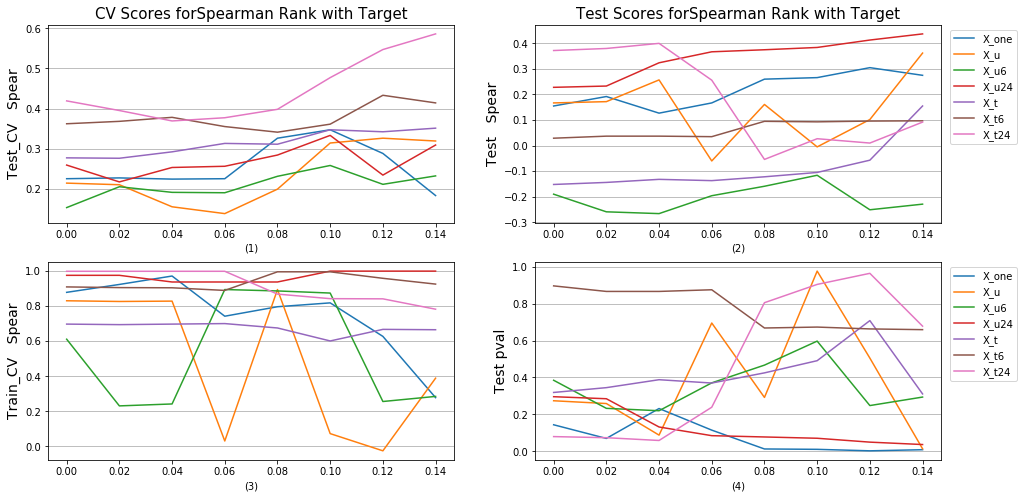

--------------------------------------------------------------------------


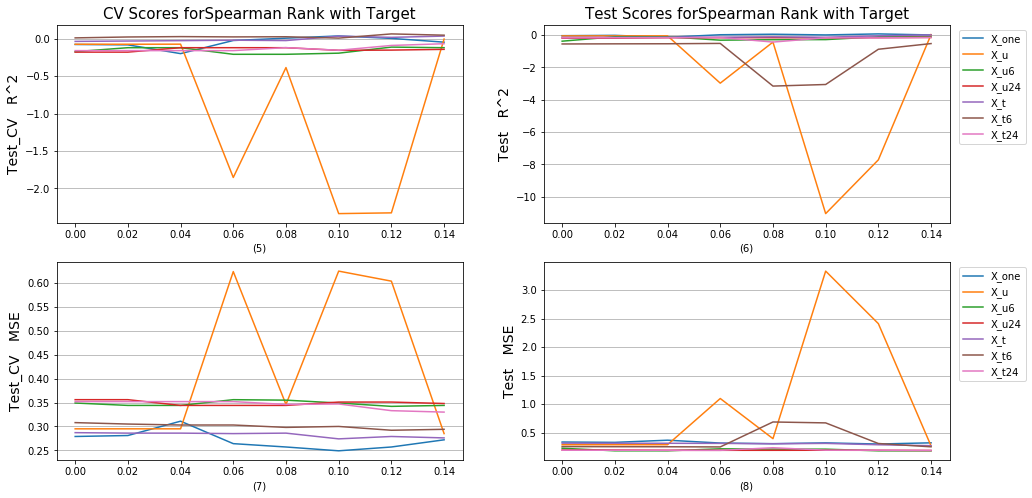

--------------------------------------------------------------------------


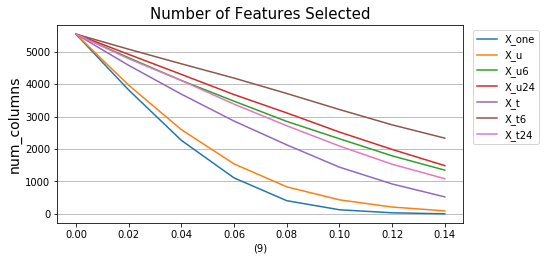

In [422]:
graph_threshold_scores(df = spear_tar_results, title = "Spearman Rank with Target", 
                       x_ax = 'threshold')

<a id='peartar'><a/>
    
## 8. Pearson Correlarion with Target


In [294]:
#check the threshold with the first df
X_cos = X_one.loc[:]
stats = []
  
for c in range(len(X_cos.columns)):  
    stats.append(pearsonr(X_cos.iloc[:, c].values.reshape(-1, 1), y.values.reshape(-1, 1))[0])  
    
print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

-0.004458183629273876
0.1355703417514168
-0.1527909087388783


In [319]:
np.arange(0, 0.154, 0.02)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14])

In [325]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']

dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0, 0.154, 0.02):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):     
            s, p = pearsonr(X_cos.iloc[:, c].values.reshape(-1, 1), y_frame.values.reshape(-1, 1))
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                               
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [432]:
# pears_tar_results = all_results.loc[:]
# pears_tar_bestparams = pears_tar_results['best_params'].values
# pears_tar_bestparams

In [433]:
# pears_tar_results.drop('best_params', axis = 1).head()

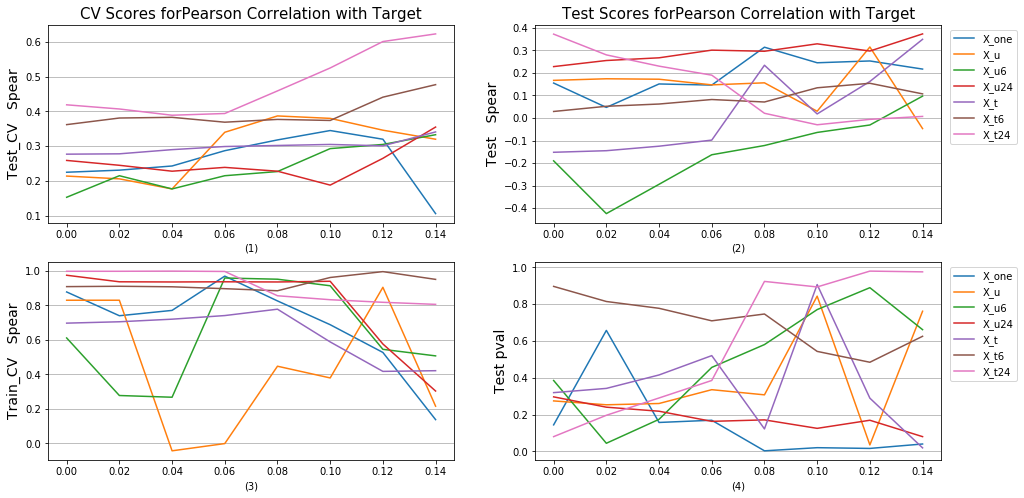

--------------------------------------------------------------------------


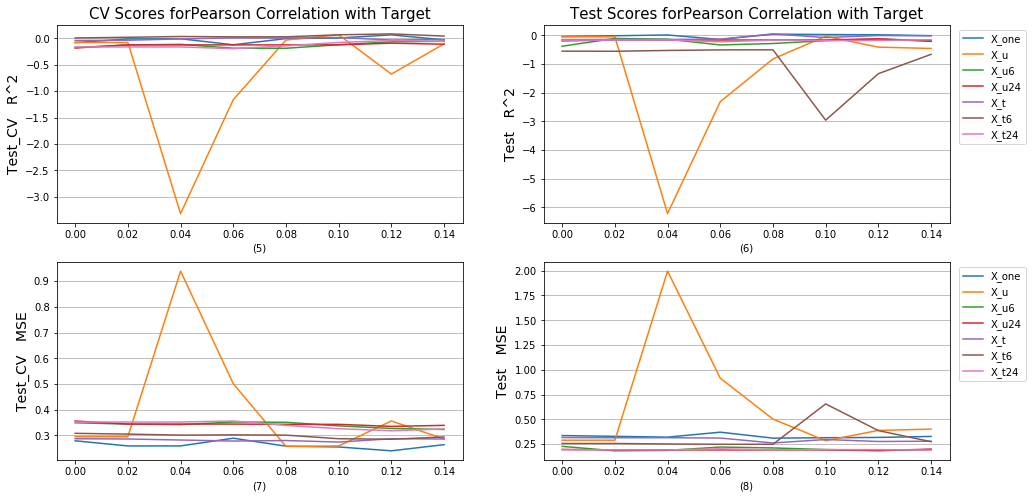

--------------------------------------------------------------------------


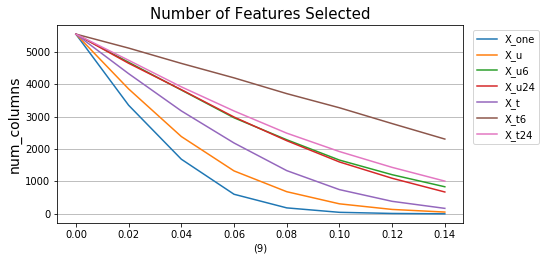

In [424]:
graph_threshold_scores(df = pears_tar_results, title = "Pearson Correlation with Target", 
                       x_ax = 'threshold')

<a id='costar'><a/>
## 9. Cosine similarity with Target

In [347]:
#check the threshold with the first df

X_cos = X_one.loc[:]
stats = []
for i in range(len(X_cos.columns)):
    stats.append(cosine_similarity(X_cos.values[:, i].reshape(1, -1), y.values.reshape(1, -1))[0][0])

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  


0.07719637668139566
0.9156989979574461
-0.9360724062789755


In [351]:
np.arange(0.1, 0.98, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [352]:
X_frames = ['X_one', 'X_u', 'X_u6', 'X_u24', 'X_t', 'X_t6', 'X_t24' ]
y_frames = ['y', 'y_u', 'y_u6', 'y_u24', 'y_t', 'y_t6', 'y_t24']

dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0.1, 0.98, 0.1):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):
            s = cosine_similarity(X_cos.values[:, c].reshape(1, -1), y_frame.values.reshape(1, -1))[0][0]
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                               
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.1, 1, 10],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [442]:
# cos_tar_results = all_results.loc[:]
# cos_tar_bestparams = cos_tar_results['best_params'].values
# cos_tar_bestparams

In [441]:
# cos_tar_results.drop('best_params', axis = 1).head()

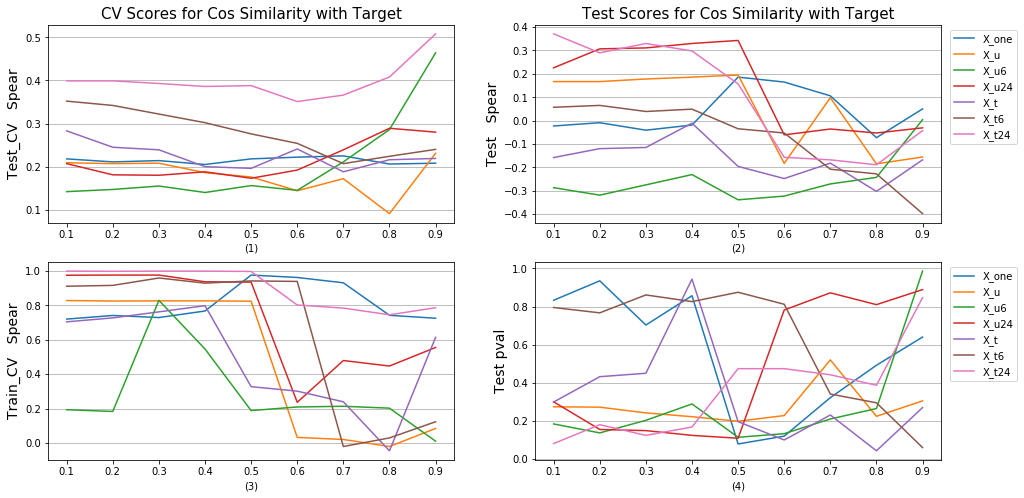

--------------------------------------------------------------------------


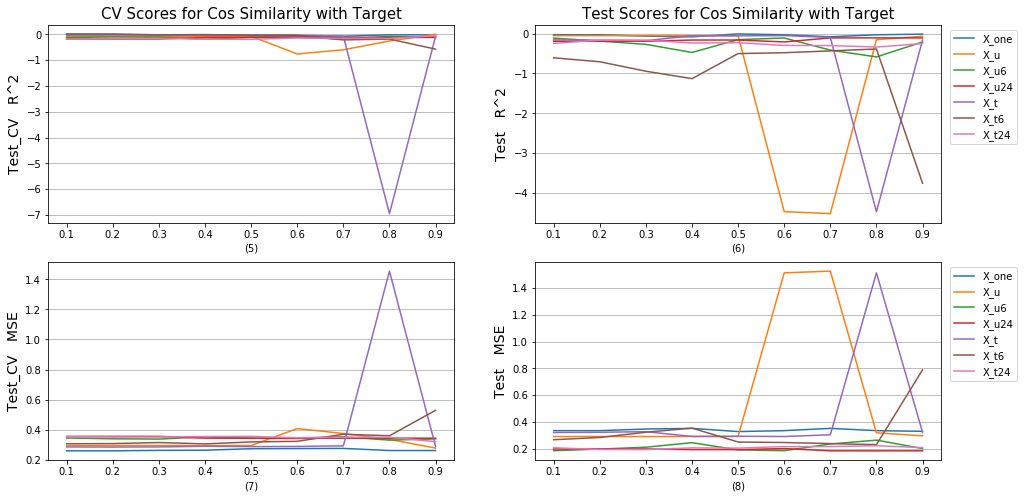

--------------------------------------------------------------------------


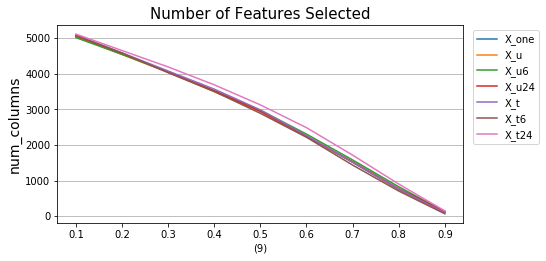

In [426]:
graph_threshold_scores(df = cos_tar_results, title = " Cos Similarity with Target", 
                       x_ax = 'threshold')